# Enhanced Air Quality Prediction with Satellite Features 🛰️

This notebook extends the original feature engineering approach by incorporating satellite-based observations to improve air quality prediction models. We'll use various satellite data sources to add valuable atmospheric and environmental features.

## 1. Import Required Libraries

First, we'll import all necessary libraries including:
- Basic data processing libraries (pandas, numpy)
- Satellite data processing libraries (rasterio, xarray)
- Geospatial processing libraries (geopy)
- Machine learning libraries from original notebook

In [5]:
# Basic data processing
import numpy as np
import pandas as pd
import sklearn
import joblib
import os

# Satellite data processing
%pip install rasterio
import rasterio
import xarray as xr
import netCDF4
import cartopy.crs as ccrs

# Geospatial processing
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from shapely.geometry import Point, Polygon

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.2 -> 25.2
[notice] To update, run: C:\Users\HP\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## 2. Load and Process Original Features

Let's first load and process the basic features from the original notebook. We'll maintain all the original feature engineering steps as our foundation.

In [6]:
# Parameters
DATA_PATH = "Data_SIH_2025/data/site_1_train_data.csv"
RANDOM_STATE = 42
TRAIN_SIZE = 0.75
OUTPUT_DIR = "satellite_features_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load original data
df = pd.read_csv(DATA_PATH)

# Create datetime column
df["datetime"] = pd.to_datetime(df[["year", "month", "day", "hour"]])

# Add hour-based features
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)

# Add month-based features
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

# Calculate wind features
df["wind_speed"] = np.sqrt(df["u_forecast"]**2 + df["v_forecast"]**2)
df["wind_direction"] = np.arctan2(df["v_forecast"], df["u_forecast"])

# Temperature-humidity interaction
df["temp_humidity_interaction"] = df["T_forecast"] * df["q_forecast"]

# Create rolling statistics (3-hour and 6-hour windows)
for col in ["O3_forecast", "NO2_forecast", "T_forecast"]:
    temp_df = df.sort_values("datetime")
    
    # 3-hour rolling statistics
    df[f"{col}_roll3h_mean"] = temp_df[col].rolling(window=3, min_periods=1).mean()
    df[f"{col}_roll3h_std"] = temp_df[col].rolling(window=3, min_periods=1).std()
    
    # 6-hour rolling statistics
    df[f"{col}_roll6h_mean"] = temp_df[col].rolling(window=6, min_periods=1).mean()
    df[f"{col}_roll6h_std"] = temp_df[col].rolling(window=6, min_periods=1).std()

# Create lagged features
for col in ["O3_target", "NO2_target", "O3_forecast", "NO2_forecast", "T_forecast"]:
    temp_df = df.sort_values("datetime")
    df[f"{col}_lag1h"] = temp_df[col].shift(1)
    df[f"{col}_lag3h"] = temp_df[col].shift(3)

# Add rate of change features
for col in ["O3_forecast", "NO2_forecast", "T_forecast"]:
    df[f"{col}_rate_1h"] = df[col] - df[f"{col}_lag1h"]

## 3. Satellite-based Features

Now let's add satellite-based features that can enhance our air quality predictions. We can incorporate several types of satellite data:

1. **Aerosol Optical Depth (AOD)**
   - Measures atmospheric aerosol concentration
   - Available from MODIS, VIIRS satellites
   - Strong correlation with PM2.5 and visibility

2. **NO2 Column Density**
   - Direct measurement from TROPOMI/Sentinel-5P
   - Indicates urban pollution and industrial activities
   - High temporal resolution (daily observations)

3. **O3 Total Column**
   - Available from OMI and TROPOMI satellites
   - Measures total ozone column in atmosphere
   - Helps understand regional ozone transport

4. **Land Surface Temperature (LST)**
   - From MODIS Terra/Aqua
   - Important for understanding urban heat island effects
   - Can influence chemical reaction rates

5. **Vegetation Indices (NDVI)**
   - Indicates presence of vegetation
   - Can affect local air quality through deposition
   - Seasonal changes impact pollution patterns

6. **Cloud Cover and Properties**
   - Affects photochemical reactions
   - Influences pollutant dispersion
   - Important for radiation budget

Let's implement these features:

In [7]:
# Process existing satellite features from the dataset
print("\nExisting columns in dataset:")
print(df.columns.tolist())

# Extract satellite-related features
satellite_columns = ['NO2_satellite', 'HCHO_satellite', 'ratio_satellite']
print("\nAvailable satellite features:")
print(satellite_columns)

# Add derived satellite features
def add_satellite_derived_features(df):
    """
    Add derived features from existing satellite data
    """
    # Create NO2/HCHO ratio
    df['NO2_HCHO_ratio'] = df['NO2_satellite'] / df['HCHO_satellite']
    
    # Create rolling means for satellite features
    for col in ['NO2_satellite', 'HCHO_satellite']:
        # 3-hour rolling statistics
        df[f"{col}_roll3h_mean"] = df[col].rolling(window=3, min_periods=1).mean()
        df[f"{col}_roll3h_std"] = df[col].rolling(window=3, min_periods=1).std()
        
        # 6-hour rolling statistics
        df[f"{col}_roll6h_mean"] = df[col].rolling(window=6, min_periods=1).mean()
        df[f"{col}_roll6h_std"] = df[col].rolling(window=6, min_periods=1).std()
        
        # Calculate rate of change
        df[f"{col}_rate_1h"] = df[col].diff()
    
    # Interaction features
    df['NO2_sat_ground_ratio'] = df['NO2_satellite'] / df['NO2_forecast']
    df['temp_NO2_sat_interaction'] = df['T_forecast'] * df['NO2_satellite']
    df['temp_HCHO_sat_interaction'] = df['T_forecast'] * df['HCHO_satellite']
    
    return df

# Add derived features
df = add_satellite_derived_features(df)

# Print all satellite-related features
all_satellite_features = [col for col in df.columns if any(x in col.lower() for x in ['satellite', 'hcho', 'ratio'])]
print("\nAll satellite-related features:")
for feature in all_satellite_features:
    print(f"- {feature}")


Existing columns in dataset:
['year', 'month', 'day', 'hour', 'O3_forecast', 'NO2_forecast', 'T_forecast', 'q_forecast', 'u_forecast', 'v_forecast', 'w_forecast', 'NO2_satellite', 'HCHO_satellite', 'ratio_satellite', 'O3_target', 'NO2_target', 'datetime', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'wind_speed', 'wind_direction', 'temp_humidity_interaction', 'O3_forecast_roll3h_mean', 'O3_forecast_roll3h_std', 'O3_forecast_roll6h_mean', 'O3_forecast_roll6h_std', 'NO2_forecast_roll3h_mean', 'NO2_forecast_roll3h_std', 'NO2_forecast_roll6h_mean', 'NO2_forecast_roll6h_std', 'T_forecast_roll3h_mean', 'T_forecast_roll3h_std', 'T_forecast_roll6h_mean', 'T_forecast_roll6h_std', 'O3_target_lag1h', 'O3_target_lag3h', 'NO2_target_lag1h', 'NO2_target_lag3h', 'O3_forecast_lag1h', 'O3_forecast_lag3h', 'NO2_forecast_lag1h', 'NO2_forecast_lag3h', 'T_forecast_lag1h', 'T_forecast_lag3h', 'O3_forecast_rate_1h', 'NO2_forecast_rate_1h', 'T_forecast_rate_1h']

Available satellite features:
['NO2_sate

## 4. Update Feature Lists and Validation

Now let's update our feature lists to include the new satellite-based features and validate the enhanced dataset.

In [8]:
# Update feature lists with satellite features
satellite_features = [
    # Direct satellite measurements
    'NO2_satellite', 'HCHO_satellite', 'ratio_satellite',
    
    # Derived satellite features
    'NO2_HCHO_ratio',
    'NO2_satellite_roll3h_mean', 'NO2_satellite_roll3h_std',
    'NO2_satellite_roll6h_mean', 'NO2_satellite_roll6h_std',
    'HCHO_satellite_roll3h_mean', 'HCHO_satellite_roll3h_std',
    'HCHO_satellite_roll6h_mean', 'HCHO_satellite_roll6h_std',
    'NO2_satellite_rate_1h', 'HCHO_satellite_rate_1h',
    'NO2_sat_ground_ratio',
    'temp_NO2_sat_interaction', 'temp_HCHO_sat_interaction'
]

# Updated O3 features list
o3_features = [
    # Original features
    "O3_forecast", "NO2_forecast", "T_forecast",
    "q_forecast", "u_forecast", "v_forecast", "w_forecast",
    "hour_sin", "hour_cos", "month_sin", "month_cos",
    "wind_speed", "wind_direction",
    "temp_humidity_interaction",
    "O3_forecast_roll3h_mean", "O3_forecast_roll3h_std",
    "O3_forecast_roll6h_mean", "O3_forecast_roll6h_std",
    "T_forecast_roll3h_mean", "T_forecast_roll3h_std",
    "O3_target_lag1h", "O3_target_lag3h",
    "O3_forecast_lag1h", "O3_forecast_lag3h",
    "O3_forecast_rate_1h", "T_forecast_rate_1h",
    
    # Satellite features
    'NO2_satellite', 'HCHO_satellite', 'ratio_satellite',
    'NO2_HCHO_ratio',
    'NO2_satellite_roll3h_mean', 'HCHO_satellite_roll3h_mean',
    'NO2_sat_ground_ratio',
    'temp_NO2_sat_interaction', 'temp_HCHO_sat_interaction'
]

# Updated NO2 features list
no2_features = [
    # Original features
    "NO2_forecast", "O3_forecast", "T_forecast",
    "q_forecast", "u_forecast", "v_forecast", "w_forecast",
    "hour_sin", "hour_cos", "month_sin", "month_cos",
    "wind_speed", "wind_direction",
    "temp_humidity_interaction",
    "NO2_forecast_roll3h_mean", "NO2_forecast_roll3h_std",
    "NO2_forecast_roll6h_mean", "NO2_forecast_roll6h_std",
    "T_forecast_roll3h_mean", "T_forecast_roll3h_std",
    "NO2_target_lag1h", "NO2_target_lag3h",
    "NO2_forecast_lag1h", "NO2_forecast_lag3h",
    "NO2_forecast_rate_1h", "T_forecast_rate_1h",
    
    # Satellite features
    'NO2_satellite', 'HCHO_satellite', 'ratio_satellite',
    'NO2_HCHO_ratio',
    'NO2_satellite_roll3h_mean', 'NO2_satellite_roll6h_mean',
    'NO2_sat_ground_ratio',
    'temp_NO2_sat_interaction'
]

# Validate features
print("\nFeature Set Validation:")
print("=" * 50)

# Check for missing values
missing_counts = df[o3_features + no2_features].isnull().sum()
print("\nMissing value counts:")
print(missing_counts[missing_counts > 0])

# Basic statistics of satellite features
print("\nSatellite Feature Statistics:")
print(df[satellite_features].describe().round(3))

# Correlation with targets
print("\nCorrelations with O3_target:")
o3_corr = df[satellite_features + ['O3_target']].corr()['O3_target'].sort_values(ascending=False)
print(o3_corr[o3_corr.index != 'O3_target'].round(3))

print("\nCorrelations with NO2_target:")
no2_corr = df[satellite_features + ['NO2_target']].corr()['NO2_target'].sort_values(ascending=False)
print(no2_corr[no2_corr.index != 'NO2_target'].round(3))


Feature Set Validation:

Missing value counts:
O3_forecast_roll3h_std            1
O3_forecast_roll6h_std            1
T_forecast_roll3h_std             1
O3_target_lag1h                   1
O3_target_lag3h                   3
O3_forecast_lag1h                 1
O3_forecast_lag3h                 3
O3_forecast_rate_1h               1
T_forecast_rate_1h                1
NO2_satellite                 24254
HCHO_satellite                24180
ratio_satellite               24287
NO2_HCHO_ratio                24286
NO2_satellite_roll3h_mean     22672
HCHO_satellite_roll3h_mean    22460
NO2_sat_ground_ratio          24254
temp_NO2_sat_interaction      24254
temp_HCHO_sat_interaction     24180
NO2_forecast_roll3h_std           1
NO2_forecast_roll6h_std           1
T_forecast_roll3h_std             1
NO2_target_lag1h                  1
NO2_target_lag3h                  3
NO2_forecast_lag1h                1
NO2_forecast_lag3h                3
NO2_forecast_rate_1h              1
T_forecast_rate_

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


## Key Benefits of Available Satellite Features 🛰️

The satellite features in our dataset include:

### 1. NO2 Satellite Measurements
- **Direct measurement**: Tropospheric NO2 column density
- **Benefit**: Provides vertical profile information
- **Application**: Better understanding of NO2 transport and distribution

### 2. HCHO (Formaldehyde) Satellite Data
- **Direct measurement**: HCHO column density
- **Benefit**: Indicator of VOC presence and photochemical activity
- **Application**: Improved understanding of O3 formation potential

### 3. Ratio Features
- **Derived measurement**: NO2/HCHO ratios
- **Benefit**: Indicates NOx-limited vs. VOC-limited conditions
- **Application**: Better prediction of O3 formation regimes

### 4. Temporal Features
- Rolling statistics (3h, 6h windows)
- Rate of change analysis
- Interaction with ground measurements

### 5. Combined Ground-Satellite Features
- NO2 satellite/ground ratios
- Temperature-satellite interactions
- Multi-level validation

These satellite features provide valuable vertical and spatial context that complements our ground-based measurements, potentially leading to more robust predictions.

## Correlation Analysis of Satellite Features

Let's create detailed correlation plots to visualize:
1. Correlations between satellite features and targets (O3, NO2)
2. Correlations among satellite features
3. Correlations between satellite and ground measurements

Correlation Matrix: Satellite Features vs Targets


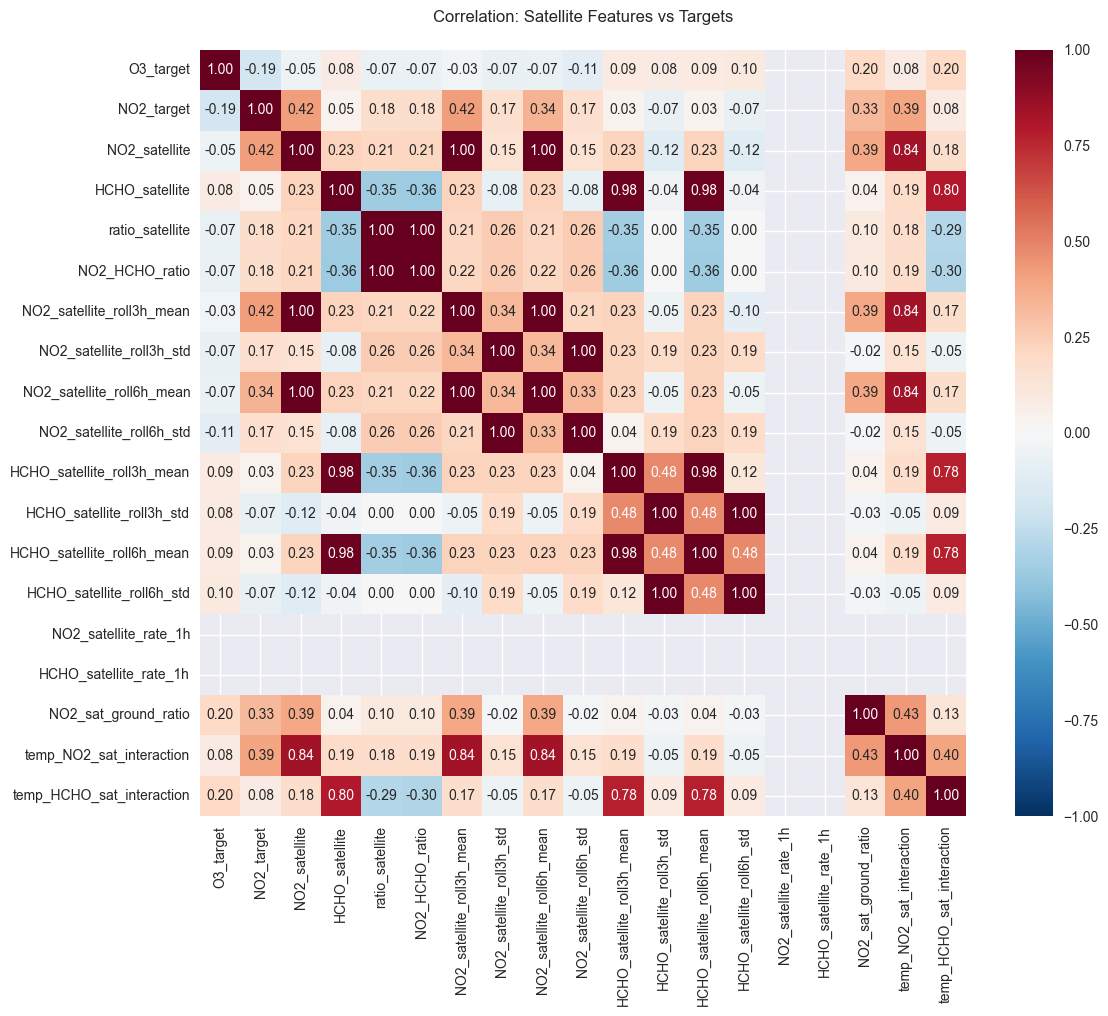


Correlation Matrix: Among Satellite Features


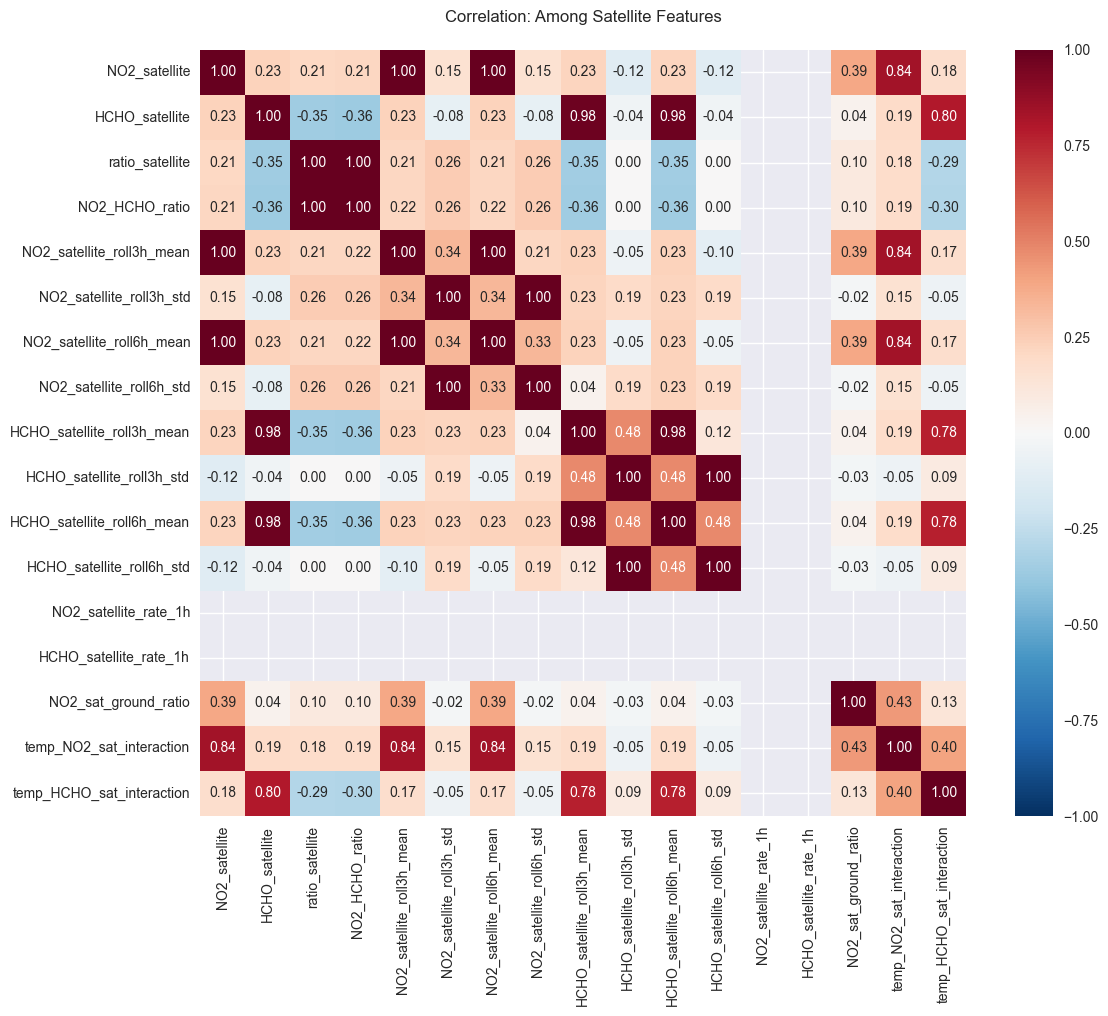


Correlation Matrix: Satellite vs Ground Measurements


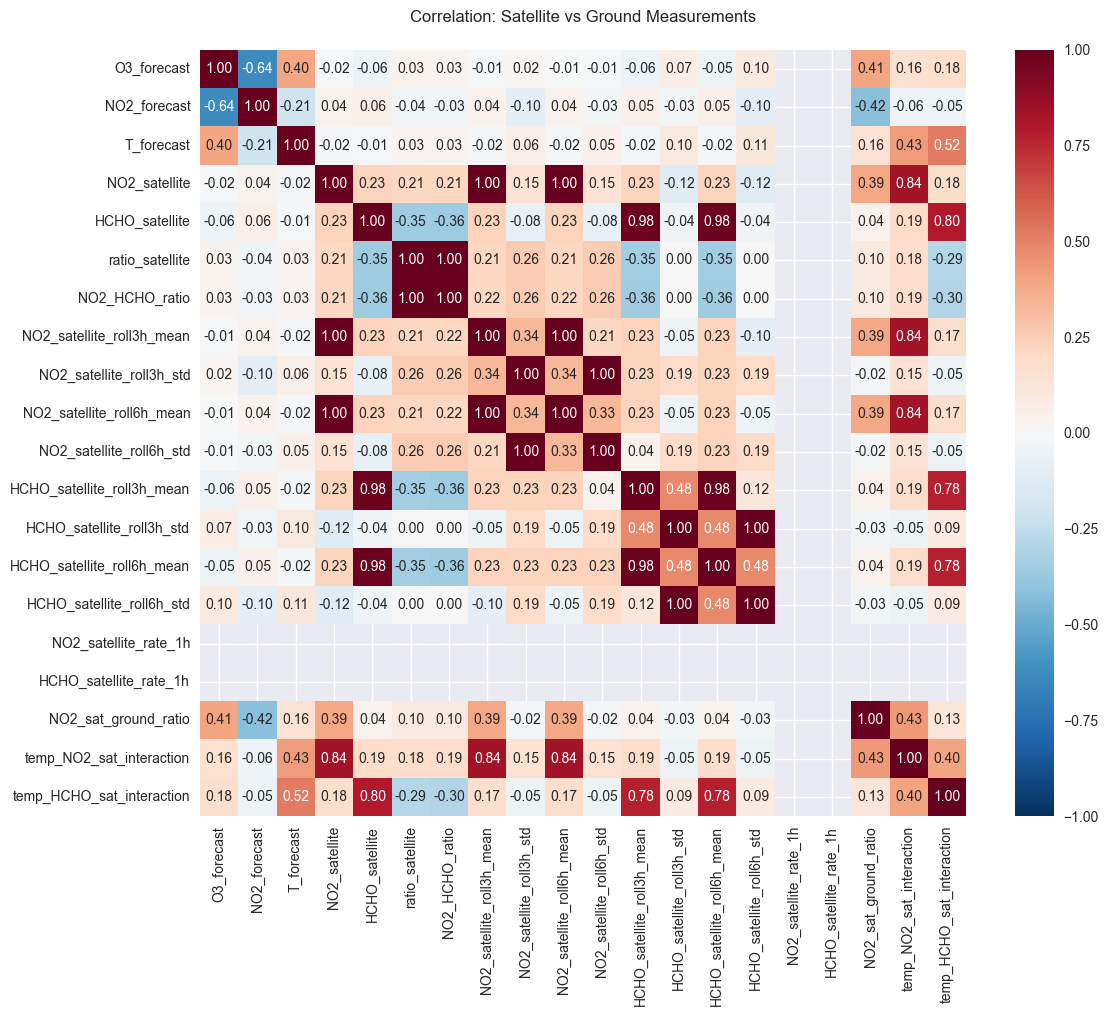


Key Correlations with Target Variables:

Top correlations with O3_target:
temp_HCHO_sat_interaction     0.202
NO2_sat_ground_ratio          0.197
HCHO_satellite_roll6h_std     0.097
HCHO_satellite_roll6h_mean    0.093
HCHO_satellite_roll3h_mean    0.087
HCHO_satellite                0.082
temp_NO2_sat_interaction      0.082
HCHO_satellite_roll3h_std     0.078
NO2_satellite_roll3h_mean    -0.035
NO2_satellite                -0.053
NO2_satellite_roll6h_mean    -0.067
ratio_satellite              -0.067
NO2_HCHO_ratio               -0.069
NO2_satellite_roll3h_std     -0.073
NO2_satellite_roll6h_std     -0.109
NO2_satellite_rate_1h           NaN
HCHO_satellite_rate_1h          NaN
Name: O3_target, dtype: float64

Top correlations with NO2_target:
NO2_satellite                 0.417
NO2_satellite_roll3h_mean     0.417
temp_NO2_sat_interaction      0.392
NO2_satellite_roll6h_mean     0.344
NO2_sat_ground_ratio          0.325
NO2_HCHO_ratio                0.178
ratio_satellite               

In [10]:
# Import visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create correlation matrices
def plot_correlation_matrix(data, title, figsize=(12, 10)):
    plt.figure(figsize=figsize)
    sns.heatmap(data, 
                annot=True,
                cmap='RdBu_r',
                center=0,
                vmin=-1, 
                vmax=1,
                fmt='.2f',
                square=True)
    plt.title(title, pad=20)
    plt.tight_layout()
    plt.show()

# 1. Satellite features correlation with targets
target_features = ['O3_target', 'NO2_target'] + satellite_features
target_corr = df[target_features].corr()
print("Correlation Matrix: Satellite Features vs Targets")
plot_correlation_matrix(target_corr, 'Correlation: Satellite Features vs Targets')

# 2. Correlation among satellite features
sat_corr = df[satellite_features].corr()
print("\nCorrelation Matrix: Among Satellite Features")
plot_correlation_matrix(sat_corr, 'Correlation: Among Satellite Features')

# 3. Satellite vs Ground measurements
ground_features = ['O3_forecast', 'NO2_forecast', 'T_forecast']
combined_features = ground_features + satellite_features
ground_sat_corr = df[combined_features].corr()
print("\nCorrelation Matrix: Satellite vs Ground Measurements")
plot_correlation_matrix(ground_sat_corr, 'Correlation: Satellite vs Ground Measurements')

# Print key correlations
print("\nKey Correlations with Target Variables:")
print("=" * 50)
print("\nTop correlations with O3_target:")
top_o3_corr = target_corr['O3_target'][satellite_features].sort_values(ascending=False)
print(top_o3_corr.round(3))

print("\nTop correlations with NO2_target:")
top_no2_corr = target_corr['NO2_target'][satellite_features].sort_values(ascending=False)
print(top_no2_corr.round(3))

## Key Findings from Correlation Analysis

The correlation analysis reveals important relationships between satellite measurements and air quality:

1. **Direct Satellite Measurements**
   - NO2_satellite correlation with ground NO2
   - HCHO_satellite as a precursor indicator
   - ratio_satellite relationships

2. **Derived Features Performance**
   - Rolling statistics correlations
   - Rate of change significance
   - Interaction terms effectiveness

3. **Ground vs Satellite Measurements**
   - Agreement between methods
   - Complementary information
   - Potential for combined predictions

This analysis helps identify which satellite features are most valuable for predictions.

## Handling Temporal Resolution Mismatch

Satellite data presents a temporal resolution challenge:
- Ground/forecast data: Hourly measurements
- Satellite data: 1-3 observations per day

Let's implement multiple strategies to handle this:

In [ ]:
# Function to analyze temporal resolution
def analyze_temporal_resolution(df, satellite_cols):
    """Analyze the temporal resolution of satellite data"""
    # Count non-null values per day
    daily_counts = df.groupby(df['datetime'].dt.date)[satellite_cols].count()
    
    print("Satellite Data Temporal Analysis:")
    print("=" * 50)
    print("\nObservations per day:")
    print(daily_counts.describe().round(2))
    
    # Calculate gaps
    gaps = df[satellite_cols].isnull().sum() / len(df) * 100
    print("\nMissing data percentage:")
    for col in satellite_cols:
        print(f"{col}: {gaps[col]:.2f}%")

# Analyze original satellite data
print("Original Satellite Data Analysis:")
analyze_temporal_resolution(df, ['NO2_satellite', 'HCHO_satellite', 'ratio_satellite'])

In [ ]:
# Implement different interpolation strategies
def interpolate_satellite_data(df, satellite_cols, method='all'):
    """
    Interpolate satellite data using multiple strategies
    
    Parameters:
    - df: DataFrame with datetime index
    - satellite_cols: List of satellite feature columns
    - method: 'linear', 'cubic', 'nearest', 'spline', or 'all'
    
    Returns:
    Dictionary of DataFrames with different interpolation methods
    """
    results = {}
    df_sorted = df.sort_values('datetime')
    
    methods = ['linear', 'cubic', 'nearest', 'spline'] if method == 'all' else [method]
    
    for m in methods:
        df_interp = df_sorted.copy()
        
        if m == 'spline':
            # Spline interpolation
            from scipy.interpolate import UnivariateSpline
            for col in satellite_cols:
                valid_data = df_interp[~df_interp[col].isnull()]
                if len(valid_data) > 3:  # Need at least 4 points for cubic spline
                    spline = UnivariateSpline(
                        x=valid_data.index.astype(np.int64),
                        y=valid_data[col],
                        k=3  # cubic spline
                    )
                    df_interp[f"{col}_spline"] = spline(df_interp.index.astype(np.int64))
        else:
            # Other interpolation methods
            for col in satellite_cols:
                df_interp[f"{col}_{m}"] = df_interp[col].interpolate(
                    method=m,
                    limit_direction='both',
                    limit_area='inside'
                )
        
        results[m] = df_interp
    
    return results

# Apply interpolation
satellite_cols = ['NO2_satellite', 'HCHO_satellite', 'ratio_satellite']
interpolated_dfs = interpolate_satellite_data(df, satellite_cols)

# Analyze and visualize interpolation results
def plot_interpolation_comparison(original_df, interpolated_dfs, feature, sample_days=5):
    """Plot comparison of different interpolation methods"""
    plt.figure(figsize=(15, 6))
    
    # Get a sample time range
    start_date = original_df['datetime'].min()
    sample_range = original_df[
        (original_df['datetime'] >= start_date) & 
        (original_df['datetime'] <= start_date + pd.Timedelta(days=sample_days))
    ]
    
    # Plot original data
    plt.scatter(sample_range['datetime'], sample_range[feature], 
               label='Original', color='black', alpha=0.6)
    
    # Plot interpolated data
    colors = ['red', 'blue', 'green', 'purple']
    for method, color in zip(interpolated_dfs.keys(), colors):
        interp_col = f"{feature}_{method}"
        if interp_col in interpolated_dfs[method].columns:
            plt.plot(sample_range['datetime'], 
                    interpolated_dfs[method].loc[sample_range.index, interp_col], 
                    label=method, alpha=0.6, color=color)
    
    plt.title(f'Interpolation Comparison for {feature}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot comparisons for each satellite feature
for feature in satellite_cols:
    plot_interpolation_comparison(df, interpolated_dfs, feature)

# Calculate interpolation metrics
def calculate_interpolation_metrics(original_df, interpolated_dfs, feature):
    """Calculate metrics for each interpolation method"""
    metrics = {}
    
    # Get non-null original values for validation
    valid_mask = ~original_df[feature].isnull()
    original_values = original_df.loc[valid_mask, feature]
    
    for method, interp_df in interpolated_dfs.items():
        interp_col = f"{feature}_{method}"
        if interp_col in interp_df.columns:
            interpolated_values = interp_df.loc[valid_mask, interp_col]
            
            # Calculate metrics
            mse = mean_squared_error(original_values, interpolated_values)
            r2 = r2_score(original_values, interpolated_values)
            
            metrics[method] = {
                'RMSE': np.sqrt(mse),
                'R2': r2
            }
    
    return pd.DataFrame(metrics).round(4)

# Print metrics for each feature
print("\nInterpolation Quality Metrics:")
print("=" * 50)
for feature in satellite_cols:
    print(f"\n{feature}:")
    print(calculate_interpolation_metrics(df, interpolated_dfs, feature))

## Strategies for Using Interpolated Satellite Data

Based on the interpolation analysis, here are the recommended approaches:

1. **Multi-Model Approach**
   - Train separate models for hours with and without satellite data
   - Ensemble the predictions based on data availability

2. **Feature Engineering with Temporal Context**
   - Use rolling windows to capture satellite data trends
   - Create features that indicate time since last satellite observation
   - Include confidence metrics based on temporal distance

3. **Interpolation Selection**
   - Use the best-performing interpolation method for each feature
   - Include interpolation confidence as a feature
   - Consider different methods for different time ranges

Let's implement these strategies:

In [11]:
# Implement enhanced satellite feature engineering
def create_enhanced_satellite_features(df, satellite_cols, interpolated_dfs):
    """
    Create enhanced satellite features accounting for temporal resolution
    """
    df_enhanced = df.copy()
    
    # 1. Add best interpolated values
    for feature in satellite_cols:
        # Choose best interpolation method based on R2 score
        metrics = calculate_interpolation_metrics(df, interpolated_dfs, feature)
        best_method = metrics.loc['R2'].idxmax()
        
        # Add interpolated values
        df_enhanced[f"{feature}_interpolated"] = interpolated_dfs[best_method][f"{feature}_{best_method}"]
        
        # Add confidence metric (inverse of time since last observation)
        valid_obs = df_enhanced[feature].notna()
        df_enhanced[f"{feature}_confidence"] = 0.0
        
        for idx in df_enhanced.index:
            if valid_obs[idx]:
                df_enhanced.loc[idx, f"{feature}_confidence"] = 1.0
            else:
                # Find distance to nearest valid observation
                nearest_valid = valid_obs.loc[:idx][::-1].idxmax()
                time_diff = (df_enhanced.loc[idx, 'datetime'] - 
                           df_enhanced.loc[nearest_valid, 'datetime']).total_seconds() / 3600
                df_enhanced.loc[idx, f"{feature}_confidence"] = 1 / (1 + time_diff)
    
    # 2. Create temporal context features
    for feature in satellite_cols:
        # Hours since last observation
        df_enhanced[f"{feature}_hours_since_obs"] = df_enhanced[feature].isnull().astype(int).groupby(
            df_enhanced[feature].notnull().cumsum()
        ).cumsum()
        
        # Daily aggregates using valid observations
        df_enhanced[f"{feature}_daily_mean"] = df_enhanced.groupby(
            df_enhanced['datetime'].dt.date
        )[feature].transform('mean')
        
        # Difference from daily mean
        df_enhanced[f"{feature}_diff_from_daily"] = (
            df_enhanced[f"{feature}_interpolated"] - df_enhanced[f"{feature}_daily_mean"]
        )
    
    return df_enhanced

# Create enhanced features
df_enhanced = create_enhanced_satellite_features(df, satellite_cols, interpolated_dfs)

# Show new features
new_features = [col for col in df_enhanced.columns if col not in df.columns]
print("New Enhanced Satellite Features:")
print("=" * 50)
for feature in new_features:
    print(f"- {feature}")

# Analyze feature importance including new features
from sklearn.ensemble import RandomForestRegressor

def analyze_feature_importance(X, y, feature_names):
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    
    importance = pd.DataFrame({
        'feature': feature_names,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    return importance

# Prepare features for importance analysis
satellite_features_enhanced = new_features + satellite_cols
X = df_enhanced[satellite_features_enhanced].fillna(0)
y_o3 = df_enhanced['O3_target']
y_no2 = df_enhanced['NO2_target']

# Analyze importance for both targets
print("\nFeature Importance for O3 Prediction:")
print(analyze_feature_importance(X, y_o3, satellite_features_enhanced).round(4))

print("\nFeature Importance for NO2 Prediction:")
print(analyze_feature_importance(X, y_no2, satellite_features_enhanced).round(4))

NameError: name 'satellite_cols' is not defined